In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import statsmodels.api as sm

In [37]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
yen_futures = pd.read_csv(Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
yen_futures = yen_futures.loc["2015-01-01":, :]

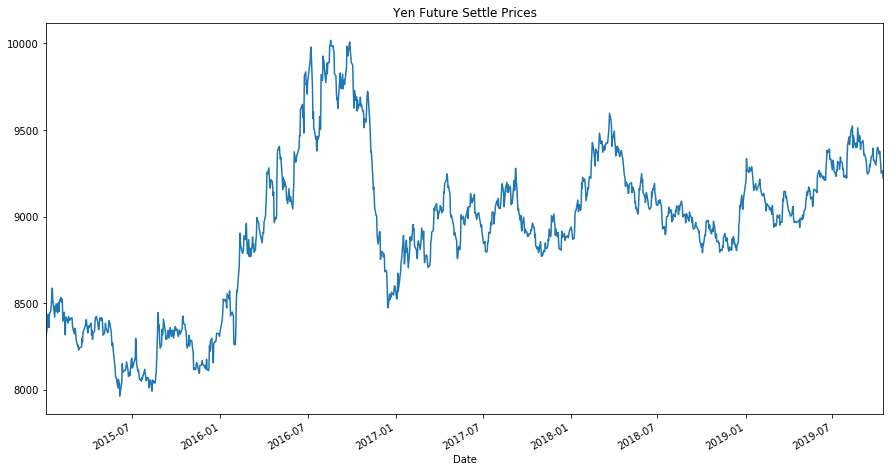

In [4]:
yen_futures.Settle.plot(title="Yen Future Settle Prices",figsize=(15,8))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [6]:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [7]:
yen_hp = pd.DataFrame(yen_futures['Settle'].copy())
yen_hp["noise"] = ts_noise 
yen_hp["trend"] = ts_trend 
yen_hp.head()

,Settle,noise,trend
Date,,,
2015-01-02,8315.0,-88.677356,8403.677356
2015-01-05,8371.0,-40.889239,8411.889239
2015-01-06,8435.0,14.954303,8420.045697
2015-01-07,8412.0,-16.065754,8428.065754
2015-01-08,8360.0,-75.877775,8435.877775


# HP Filter

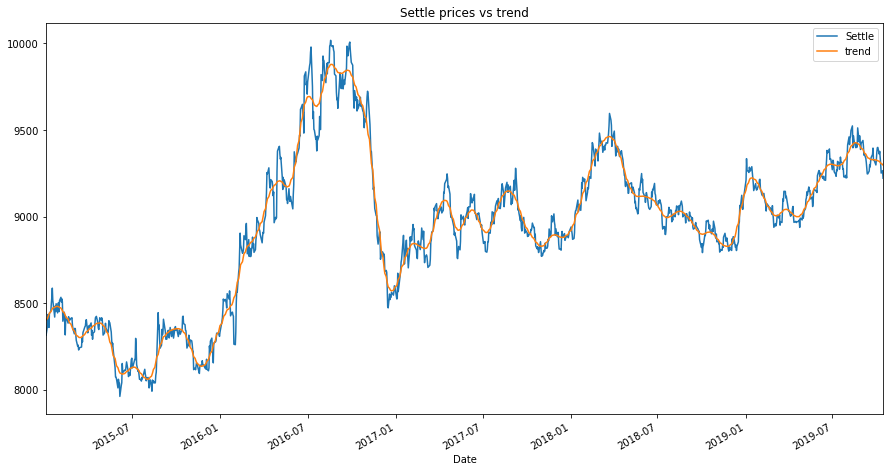

In [41]:
yen_hp[['Settle','trend']].plot(title='Settle prices vs trend',figsize=(15,8)).get_figure().savefig('hpfilter.png')

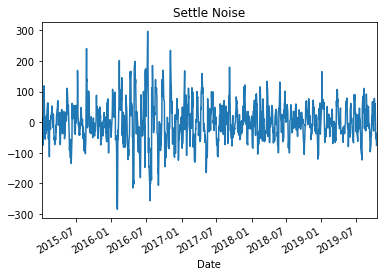

In [10]:
yen_hp['noise'].plot(title='Settle Noise')

# ARMA Model

In [11]:
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [12]:
from statsmodels.tsa.stattools import adfuller

adfuller(returns.Settle)

(-23.978364301592013,
 0.0,
 1,
 1203,
 {'1%': -3.4357974716016093,
  '5%': -2.8639455255208186,
  '10%': -2.5680507439699447},
 1955.8177195028545)

In [13]:
from statsmodels.tsa.arima_model import ARMA
arma_model = ARMA(returns.values, order=(2,1))
results = arma_model.fit()

In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1205
Model:                     ARMA(2, 1)   Log Likelihood                -998.831
Method:                       css-mle   S.D. of innovations              0.554
Date:                Mon, 31 Aug 2020   AIC                           2007.662
Time:                        21:06:10   BIC                           2033.133
Sample:                             0   HQIC                          2017.255
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0102      0.016      0.623      0.533      -0.022       0.042
ar.L1.y        0.1770      0.378      0.468      0.640      -0.565       0.919
ar.L2.y        0.0502      0.030      1.651      0.099      -0.009       0.110
ma.L1.y       -0.2112      0.378     -0.559      0.576      -0.952       0.530
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.0357           +0.0000j            3.0357            0.0000
AR.2           -6.5619           +0.0000j            6.5619            0.5000
MA.1            4.7342           +0.0000j            4.7342            0.0000
-----------------------------------------------------------------------------
"""

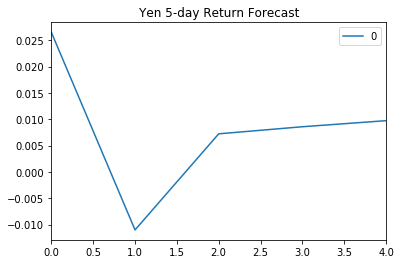

In [15]:
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Yen 5-day Return Forecast")

# ARIMA Model

In [16]:
from statsmodels.tsa.arima_model import ARIMA

In [17]:
arima_model = ARIMA(yen_futures['Settle'], order=(5, 1, 1))
arima_result = arima_model.fit()

/Users/kimcurvo/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/kimcurvo/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [18]:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 1205
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -6417.416
Method:                       css-mle   S.D. of innovations             49.735
Date:                Mon, 31 Aug 2020   AIC                          12850.832
Time:                        20:58:35   BIC                          12891.586
Sample:                             1   HQIC                         12866.180
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7591      1.418      0.535      0.593      -2.021       3.539
ar.L1.D.Settle    -0.7971      0.265     -3.011      0.003      -1.316      -0.278
ar.L2.D.Settle     0.0234      0.038      0.614      0.539      -0.051       0.098
ar.L3.D.Settle     0.0649      0.039      1.680      0.093      -0.011       0.141
ar.L4.D.Settle    -0.0096      0.038     -0.256      0.798      -0.083       0.064
ar.L5.D.Settle    -0.0641      0.032     -2.016      0.044      -0.126      -0.002
ma.L1.D.Settle     0.7647      0.265      2.885      0.004       0.245       1.284
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1848           -0.0000j            1.1848           -0.5000
AR.2           -1.1019           -1.3697j            1.7579           -0.3578
AR.3           -1.1019           +1.3697j            1.7579            0.3578
AR.4            1.6193           -1.2801j            2.0641           -0.1065
AR.5            1.6193           +1.2801j            2.0641            0.1065
MA.1           -1.3078           +0.0000j            1.3078            0.5000
-----------------------------------------------------------------------------
"""

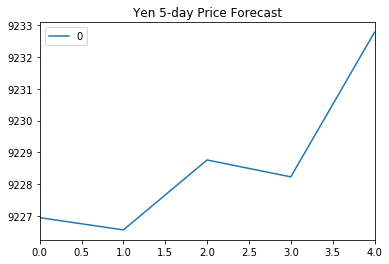

In [19]:
pd.DataFrame(arima_result.forecast(steps=5)[0]).plot(title="Yen 5-day Price Forecast")

# GARCH

In [20]:
from arch import arch_model

In [21]:
garch_returns = yen_futures.Settle.pct_change() * 100
garch_returns=garch_returns.dropna()

In [22]:
garch_returns.head()

Date
2015-01-05    0.673482
2015-01-06    0.764544
2015-01-07   -0.272673
2015-01-08   -0.618165
2015-01-09    0.944976
Name: Settle, dtype: float64

In [23]:
garch_model = arch_model(garch_returns, mean="Zero", vol="GARCH", p=2, q=1)
res = garch_model.fit(disp="off")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -937.604
Distribution:                  Normal   AIC:                           1883.21
Method:            Maximum Likelihood   BIC:                           1903.59
                                        No. Observations:                 1205
Date:                Mon, Aug 31 2020   Df Residuals:                     1201
Time:                        20:58:41   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.4897e-03  2.025e-03      0.736      0.462 [-2.478e-03,5.458e-03]
alpha[1]       0.0273  3.327e-02      0.822      0.411 [-3.787e-02,9.256e-02]
alpha[2]   1.7297e-09  4.432e-02  3.902e-08      1.000 [-8.687e-02,8.687e-02]
beta[1]        0.9676  2.540e-02     38.089      0.000      [  0.918,  1.017]
=============================================================================

Covariance estimator: robust
"""

In [24]:
last_day = garch_returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

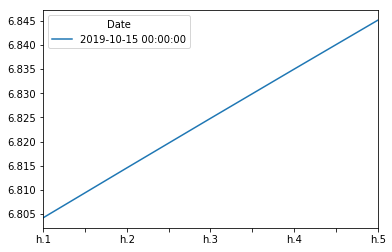

In [25]:
forecast_horizon = 5
forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
final = intermediate.dropna().T
final.plot()

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

## LINEAR REGRESSION

In [26]:
yen_futures["Returns"] = yen_futures["Settle"].copy().pct_change()*100
yen_futures["Lagged Return"] = yen_futures["Returns"].shift()
yen_futures = yen_futures.replace(-np.inf, np.nan).dropna()

In [27]:
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Returns,Lagged Return
Date,,,,,,,,,,
2015-01-06,8387.0,8476.0,8372.0,8435.0,64.0,8435.0,267472.0,225681.0,0.764544,0.673482
2015-01-07,8439.0,8443.0,8362.0,8412.0,23.0,8412.0,193647.0,226633.0,-0.272673,0.764544
2015-01-08,8384.0,8397.0,8340.0,8360.0,52.0,8360.0,145285.0,228031.0,-0.618165,-0.272673
2015-01-09,8353.0,8450.0,8347.0,8439.0,79.0,8439.0,259239.0,226889.0,0.944976,-0.618165
2015-01-12,8454.0,8471.0,8385.0,8456.0,17.0,8456.0,189397.0,226884.0,0.201446,0.944976


In [28]:
train = yen_futures[:'2017']
test = yen_futures['2018':]

In [29]:
X_train = train["Lagged Return"].to_frame()
X_test = test["Lagged Return"].to_frame()
y_train = train["Returns"]
y_test = test["Returns"]

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2a3b5810>,
      dtype=object)

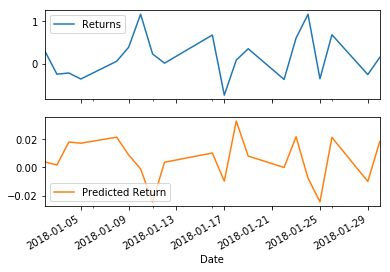

In [32]:
predictions = linear_model.predict(X_test)
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
Results[:20].plot(subplots=True)

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

In [34]:
mse = mean_squared_error(
    Results["Returns"],
    Results["Predicted Return"])

rmse = np.sqrt(mse)


in_sample_results = y_train.to_frame()
 
in_sample_results["In-sample Predictions"] = linear_model.predict(X_train)

in_sample_mse = mean_squared_error(
    in_sample_results["Returns"],
    in_sample_results["In-sample Predictions"])

in_sample_rmse = np.sqrt(in_sample_mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.4147422987817274
In-sample Root Mean Squared Error (RMSE): 0.6259425176093099


## Does this model perform better or worse on out-of-sample data compared to in-sample data?